In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [5]:
train.shape, test.shape

((26049, 15), (6512, 14))

In [6]:
train.head(3)
train.tail(3)
test.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
id,,,,,,,,,,,,,,,
0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,1
1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,0
2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,0


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
id,,,,,,,,,,,,,,,
26046,78,?,165694,Masters,14,Widowed,?,Not-in-family,White,Female,0,0,15,United-States,0
26047,26,Self-emp-not-inc,151626,HS-grad,9,Never-married,Prof-specialty,Own-child,Black,Female,0,0,40,United-States,0
26048,20,?,99891,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
id,,,,,,,,,,,,,,
0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States
1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States


# 2. EDA & 전처리

In [7]:
train.info()
train.describe()
train.describe(include='O')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26049 entries, 0 to 26048
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26049 non-null  int64 
 1   workclass       26049 non-null  object
 2   fnlwgt          26049 non-null  int64 
 3   education       26049 non-null  object
 4   education_num   26049 non-null  int64 
 5   marital_status  26049 non-null  object
 6   occupation      26049 non-null  object
 7   relationship    26049 non-null  object
 8   race            26049 non-null  object
 9   sex             26049 non-null  object
 10  capital_gain    26049 non-null  int64 
 11  capital_loss    26049 non-null  int64 
 12  hours_per_week  26049 non-null  int64 
 13  native_country  26049 non-null  object
 14  income          26049 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.2+ MB


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
count,26049.000000,2.604900e+04,26049.000000,26049.00000,26049.000000,26049.000000,26049.000000
mean,38.569235,1.903045e+05,10.088372,1087.68970,87.732734,40.443126,0.242044
std,13.671489,1.059663e+05,2.567610,7388.85469,403.230205,12.361850,0.428329
min,17.000000,1.376900e+04,1.000000,0.00000,0.000000,1.000000,0.000000
25%,28.000000,1.181080e+05,9.000000,0.00000,0.000000,40.000000,0.000000
50%,37.000000,1.788660e+05,10.000000,0.00000,0.000000,40.000000,0.000000
75%,48.000000,2.377350e+05,12.000000,0.00000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.00000,4356.000000,99.000000,1.000000


,workclass,education,marital_status,occupation,relationship,race,sex,native_country
count,26049,26049,26049,26049,26049,26049,26049,26049
unique,9,16,7,15,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,18123,8433,11970,3304,10541,22315,17482,23371


## Missing Value

In [8]:
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

In [9]:
train_drop = train[~(train.workclass == '?')]
df_workclass = pd.DataFrame(train_drop.groupby(['hours_per_week','sex','workclass'])['workclass'].count())
df_workclass.columns = ['count']
df_workclass = df_workclass.reset_index()
df_workclass_max = pd.DataFrame(df_workclass.groupby(['hours_per_week','sex'])['count'].max()).reset_index()
df_workclass_max = df_workclass_max.merge(df_workclass, on=['hours_per_week','sex','count'], how='inner').groupby(['hours_per_week','sex'])['count','workclass'].max().reset_index().drop('count',axis=1)
train = train.merge(df_workclass_max, on=['hours_per_week','sex'], how='left')
train.loc[train.workclass_x == '?','workclass_x'] = train['workclass_y']
train = train.rename(columns={'workclass_x':'workclass'})
train = train.drop('workclass_y', axis=1)
train

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,1
1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,0
2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,0
3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,0
4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,57,Private,250201,11th,7,Married-civ-spouse,Other-service,Husband,White,Male,0,0,52,United-States,0
26045,23,Private,238092,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
26046,78,Private,165694,Masters,14,Widowed,?,Not-in-family,White,Female,0,0,15,United-States,0
26047,26,Self-emp-not-inc,151626,HS-grad,9,Never-married,Prof-specialty,Own-child,Black,Female,0,0,40,United-States,0


In [10]:
test_drop = test[~(test.workclass == '?')]
df_workclass = pd.DataFrame(test_drop.groupby(['hours_per_week','sex','workclass'])['workclass'].count())
df_workclass.columns = ['count']
df_workclass = df_workclass.reset_index()
df_workclass_max = pd.DataFrame(df_workclass.groupby(['hours_per_week','sex'])['count'].max()).reset_index()
df_workclass_max = df_workclass_max.merge(df_workclass, on=['hours_per_week','sex','count'], how='inner').groupby(['hours_per_week','sex'])['count','workclass'].max().reset_index().drop('count',axis=1)
test = test.merge(df_workclass_max, on=['hours_per_week','sex'], how='left')
test.loc[test.workclass_x == '?','workclass_x'] = test['workclass_y']
test = test.rename(columns={'workclass_x':'workclass'})
test = test.drop('workclass_y', axis=1)
test

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States
1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States
3,40,Private,114537,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
4,37,Private,51264,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,35,Private,61343,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States
6508,41,Self-emp-inc,32185,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States
6509,39,Private,409189,5th-6th,3,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,Mexico
6510,35,Private,180342,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States


In [11]:
train.workclass.value_counts()
test.workclass.value_counts()

Private             19603
Self-emp-not-inc     2050
Local-gov            1693
State-gov            1044
Self-emp-inc          877
Federal-gov           765
Without-pay            11
Never-worked            6
Name: workclass, dtype: int64

Private             4892
Self-emp-not-inc     519
Local-gov            402
State-gov            255
Self-emp-inc         243
Federal-gov          195
Without-pay            3
Never-worked           1
Name: workclass, dtype: int64

### outlier

### education

In [12]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [13]:
df = pd.concat([train, test])
df.shape

(32561, 14)

In [14]:
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

In [15]:
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

In [16]:
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

In [17]:
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

In [18]:
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

# 3. 모델 학습

In [19]:
import gc
gc.collect()

202

In [20]:
train.columns

Index(['age', 'workclass', 'fnlwgt', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'income'],
      dtype='object')

In [21]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num']
          #, ignore_features =tp.tolist() + wr.tolist() + wf.tolist()#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 14)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 14.3 s


In [22]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.8655,0.9198,0.6478,0.7616,0.6998,0.6138,0.6174,2.7690
1,Light Gradient Boosting Machine,0.8655,0.9209,0.6465,0.7623,0.6994,0.6136,0.6172,0.3857
2,CatBoost Classifier,0.8659,0.9238,0.6335,0.7719,0.6955,0.6106,0.6158,15.4423
3,Gradient Boosting Classifier,0.8623,0.9178,0.6060,0.7765,0.6805,0.5945,0.6021,3.6880
4,Ada Boost Classifier,0.8574,0.9115,0.6180,0.7492,0.6771,0.5867,0.5913,0.9991
5,Linear Discriminant Analysis,0.8460,0.9000,0.5921,0.7219,0.6501,0.5527,0.5574,0.2215
6,Extra Trees Classifier,0.8375,0.8838,0.6024,0.6884,0.6422,0.5377,0.5400,0.7073
7,Random Forest Classifier,0.8428,0.8782,0.5636,0.7261,0.6344,0.5363,0.5434,0.1313


In [23]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8664,0.9228,0.6392,0.7700,0.6985,0.6137,0.6180
1,0.8617,0.9169,0.6553,0.7431,0.6965,0.6074,0.6094
2,0.8570,0.9215,0.6246,0.7437,0.6790,0.5879,0.5916
3,0.8695,0.9295,0.6272,0.7898,0.6992,0.6173,0.6240
4,0.8691,0.9236,0.6618,0.7659,0.7101,0.6261,0.6289
Mean,0.8648,0.9229,0.6416,0.7625,0.6966,0.6105,0.6144
SD,0.0048,0.0040,0.0148,0.0176,0.0100,0.0128,0.0131


In [24]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8721,0.9283,0.6571,0.7796,0.7131,0.6315,0.6354


In [25]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 43s


In [26]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [27]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [28]:
submission.to_csv('output/20201017-3.csv')

In [29]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8708,0.9224,0.6375,0.7880,0.7048,0.6233,0.6290
1,0.8590,0.9174,0.6699,0.7263,0.6970,0.6053,0.6062
2,0.8653,0.9188,0.6764,0.7438,0.7085,0.6212,0.6223
3,0.8574,0.9140,0.6234,0.7442,0.6784,0.5877,0.5915
4,0.8448,0.9045,0.5987,0.7143,0.6514,0.5526,0.5562
5,0.8746,0.9298,0.6472,0.7968,0.7143,0.6351,0.6407
6,0.8817,0.9349,0.6667,0.8110,0.7318,0.6568,0.6620
7,0.8597,0.9195,0.6408,0.7444,0.6887,0.5988,0.6016
8,0.8660,0.9174,0.6375,0.7695,0.6973,0.6123,0.6167
9,0.8754,0.9196,0.6796,0.7778,0.7254,0.6453,0.6477


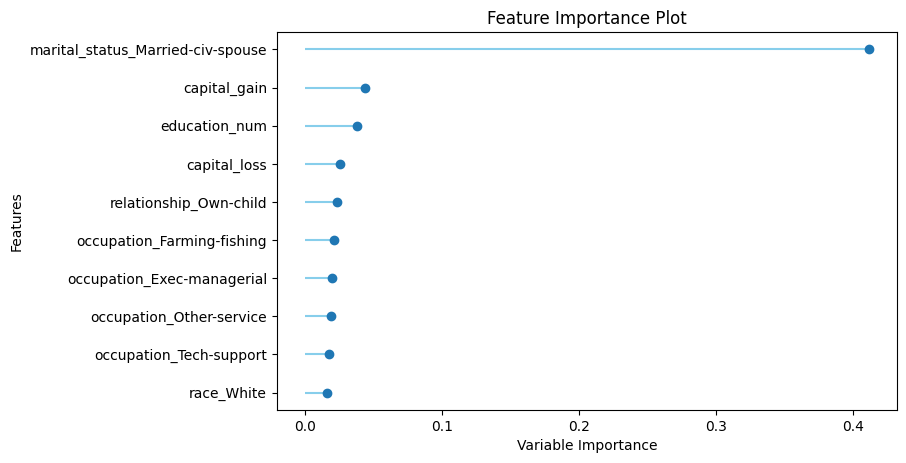

In [30]:
plot_model(estimator = xgboost, plot = 'feature')

In [31]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8653,0.9216,0.6246,0.7751,0.6918,0.6069,0.6126
1,0.8630,0.9191,0.6537,0.7481,0.6978,0.6097,0.6120
2,0.8637,0.9157,0.6764,0.7385,0.7061,0.6176,0.6186
3,0.8558,0.9125,0.6234,0.7385,0.6761,0.5842,0.5876
4,0.8503,0.9097,0.6052,0.7305,0.6619,0.5669,0.5710
5,0.8683,0.9309,0.6505,0.7701,0.7053,0.6213,0.6249
6,0.8777,0.9354,0.6570,0.8024,0.7224,0.6450,0.6503
7,0.8644,0.9177,0.6278,0.7698,0.6916,0.6059,0.6111
8,0.8746,0.9266,0.6699,0.7811,0.7213,0.6410,0.6441
9,0.8723,0.9193,0.6764,0.7684,0.7194,0.6372,0.6394


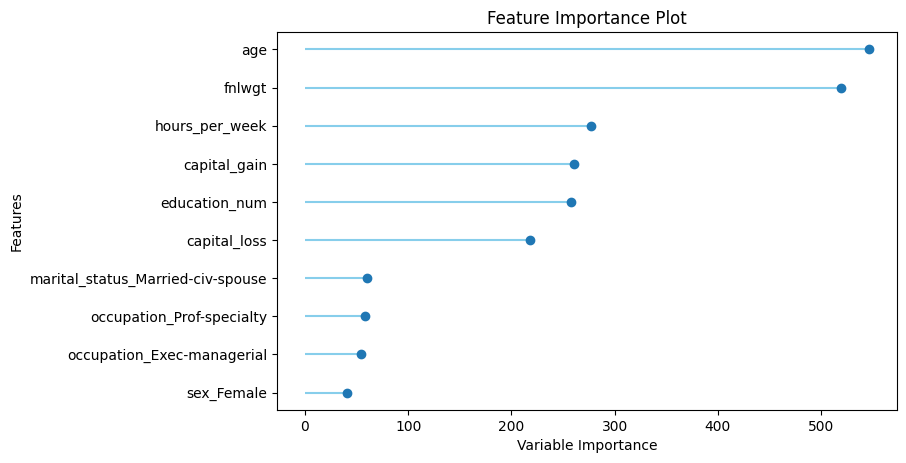

In [32]:
plot_model(estimator = lightgbm, plot = 'feature')